# ResNet
ResNet (Residual Network) is a powerful deep convolutional neural network architecture known for its ability to train very deep networks effectively using residual connections. These shortcut connections allow gradients to flow through the network more easily, solving the vanishing gradient problem and enabling the training of networks with hundreds or even thousands of layers.

In this notebook, we will apply a pre-trained ResNet-50 model to the task of classifying images as either AI-generated or human-generated. By fine-tuning the final classification layer, we adapt the model to our binary classification problem. We'll train the model on our dataset, evaluate its performance using standard metrics (accuracy, precision, recall, F1-score), and analyze how well it distinguishes between the two classes.



### Loading Dataset from Kaggle
In this subsection, we will load the dataset from Kaggle. The dataset is already organized into separate train and test folders.

We will also read and store the paths to these images for further preprocessing and usage.

In [ ]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


## Data Preprocessing
In this subsection, we will preprocess the image data to prepare it for training with the CNN model.

First, we will load the necessary libraries and read the CSV files that contain the labels for the images. These labels indicate whether each image is real or AI-generated, which will be used as the target variable for training.

In [ ]:
import os
import sys
import cv2
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import seaborn as sns
import time
import random

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import torchvision.models as models
from sklearn.model_selection import train_test_split
import random

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed(seed)  # For GPU
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python's random module
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
set_seed()

In [ ]:
# path = "/content/dataset" if "google.colab" in sys.modules else "E:/Code/Python/ML/dataset/HumanvsAi"
TRAIN_CSV = path + '/train.csv'
TEST_CSV = path + '/test.csv'
DATA_DIR = path

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df[['file_name','label']]
train_df.columns = ['id','label']

In [ ]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


To prepare our image data, we apply transformations to both training and testing sets. These transformations ensure consistency in size and format, while also enhancing training robustness through augmentation.



*   Training Transformations (`train_transform`): Includes resizing, random flips (horizontal/vertical), random rotation, Gaussian blur, and color jitter to increase data variability. Images are then converted to tensors and normalized.
*   Testing Transformations (`test_transforms`): Applies only resizing and center cropping for evaluation consistency, followed by tensor conversion and normalization.



In [ ]:
IMG_SIZE = (64,64)

In [ ]:
train_transform = T.Compose([
    T.Resize(IMG_SIZE, interpolation=InterpolationMode.BICUBIC),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(20),
    T.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
test_transforms = T.Compose([
    T.Resize(IMG_SIZE, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Splitting the Dataset
To evaluate the model’s performance reliably, we split the dataset into training and testing sets using an 80/20 ratio.

In [ ]:
train_size = len(train_df)

In [ ]:
df_train, df_test = train_test_split(train_df[:train_size], test_size=0.2, stratify=train_df.iloc[:train_size, 1],random_state=42)

Next, we define a custom Pytorch `Dataset` for handling image loading and transformation efficiently.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])  # Image filename
        image = Image.open(img_name).convert('RGB')
        label = int(self.data.iloc[idx, 1])  # Label

        if self.transform:
            image = self.transform(image)

        return image, label

Then, we initialize the datasets for training and testing

In [ ]:
train_dataset = CustomDataset(df_train, DATA_DIR, transform=train_transform)
test_dataset = CustomDataset(df_test, DATA_DIR, transform=test_transforms)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

## Transfer Learning with ResNet-50
We utilize a pre-trained ResNet-50 model for transfer learning. The original fully connected (fc) layer is replaced with a new linear layer outputting two classes, allowing the model to adapt to our Human vs. AI classification task while leveraging powerful features learned from ImageNet.

In [ ]:
model = models.resnet50(pretrained=True)
ftrs = model.fc.in_features
model.fc = nn.Linear(ftrs, 2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.6MB/s]


We load the fine-tuned ResNet-50 model weights from a saved checkpoint and move the model to GPU if available. The model is trained for 5 epochs using the AdamW optimizer with a learning rate of 0.001 and the cross-entropy loss function, which is suitable for multi-class classification tasks.

In [ ]:
# model.load_state_dict(torch.load("resnetV2_6.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# epoch
num_epochs = 5
# optimizer and loss function
optimizer = AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, train_loader, criterion, optimizer, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        start_time = time.time()

        total_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).long()  # Ensure labels are integers

            pred = model(imgs)  # Logits from ResNet
            loss = criterion(pred, labels)  # CrossEntropyLoss expects (logits, class indices)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            predicted = torch.argmax(pred, dim=1)  # Get class index
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        acc = correct / total * 100
        avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0
        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%, Time: {epoch_time:.2f}s")

train(model, train_loader, criterion, optimizer, num_epochs)


Epoch 1/5, Loss: 0.4215, Accuracy: 81.48%, Time: 1310.60s
Epoch 2/5, Loss: 0.3666, Accuracy: 84.10%, Time: 728.54s
Epoch 3/5, Loss: 0.3438, Accuracy: 85.25%, Time: 728.74s
Epoch 4/5, Loss: 0.3279, Accuracy: 85.95%, Time: 727.33s
Epoch 5/5, Loss: 0.3154, Accuracy: 86.58%, Time: 728.66s


## Model Evaluation
After training, the model is evaluated on the unseen test data to measure its generalization performance. We loop through the test dataset without computing gradients, make predictions, and compare them to the ground-truth labels. The overall accuracy is then calculated as the ratio of correctly predicted samples to the total number of samples.

In [ ]:
# testing model
model.eval()

correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8936


Next, we draw the confusion matrix to gain a deeper understanding of the model’s classification performance and evaluate how well it distinguishes between real and AI-generated images.

Test Accuracy: 0.8936


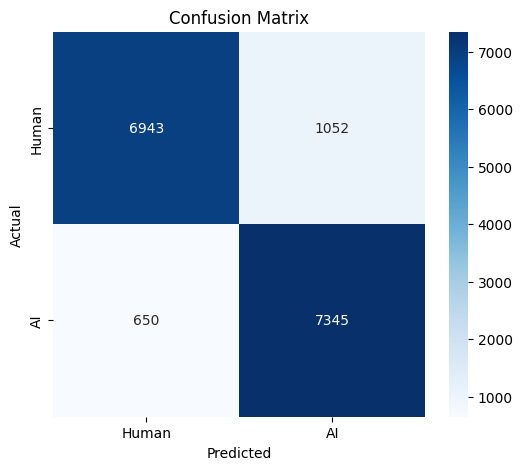

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Switch model to evaluation mode
model.eval()

correct = 0
total = 0
y_true = []  # To store true labels
y_pred = []  # To store predictions

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())  # Append true labels
        y_pred.extend(predicted.cpu().numpy())  # Append predicted labels

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


- **Accuracy**:
$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{Total}} = \frac{7345 + 6943}{15990} \approx 0.894$$

- **Precision (AI)**:
$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{7345}{7345 + 1052} \approx 0.875$$

- **Recall (AI)**:
$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{7345}{7345 + 650} \approx 0.919$$

- **F1-Score (AI)**:
$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2 \times \frac{0.875 \times 0.919}{0.875 + 0.919} \approx 0.896$$

- **Precision (Human)**:
$$\text{Precision}_{\text{Human}} = \frac{\text{TN}}{\text{TN} + \text{FN}} = \frac{6943}{6943 + 650} \approx 0.914$$

- **Recall (Human)**:
$$\text{Recall}_{\text{Human}} = \frac{\text{TN}}{\text{TN} + \text{FP}} = \frac{6943}{6943 + 1052} \approx 0.868$$

- **F1-Score (Human)**:
$$\text{F1-Score}_{\text{Human}} = 2 \times \frac{\text{Precision}_{\text{Human}} \times \text{Recall}_{\text{Human}}}{\text{Precision}_{\text{Human}} + \text{Recall}_{\text{Human}}} \approx 0.891$$

In [ ]:
torch.save(model.state_dict(), "model_fin.pth")

This stores the learned parameters in the `model_fin.pth` file, located in the default `/content/` directory (Google Colab).

To use the model for later evaluation or deployment, you should manually download this file.